# Cheat sheet on do-calculus
R notebook with NoobQuant dev conda environment R installation. Before running make sure .libPaths() contains only one, correct library path.

Dagitty installed to dev conda environment via

```install.packages("dagitty", dependencies = T)```

Useful links:
 - https://cran.r-project.org/web/packages/dagitty/vignettes/dagitty4semusers.html
 - http://www.dagitty.net/manual-3.x.pdf
 - https://cran.r-project.org/web/packages/dagitty/dagitty.pdf
 - https://nickch-k.github.io/introcausality/Cheat%20Sheets/Causal_Diagrams_Cheat_Sheet.pdf


In [1]:
#.libPaths(.libPaths()[2])
#.libPaths()

In [2]:
library(dagitty)

Warning message:
"package 'dagitty' was built under R version 3.6.3"

## Possible biases
- Collider bias
- Post-treatment bias

## Pearl's three rules of do-calculus

From *Book of Why* page 234-235.

**Rule 1**
Observing variable $W$ that is irrelevant to $Y$ (possibly conditionally o other set of variables $Z$) does not change probability distribution of $Y$.

\begin{align}
P(Y | do(X), \ Z, \ W) & = P(Y | do(X), \ Z)
\end{align}

**Rule 2**
If a set of variables $Z$ blocks all back-door paths from $X$ to $Y$, the conditional on $Z$, $do(X)$ is equivalent to $see(X)$.

\begin{align}
P(Y | do(X), \ Z) & = P(Y | X, \ Z)
\end{align}

**Rule 3**
If ther are no causal paths from $X$ to $Y$ (i.e. no paths from $X$ to $Y$ with only forward-directed arrows) then $do(X)$ has no effect on the probability distribution of $Y$. 

\begin{align}
P(Y | do(X)) & = P(Y)
\end{align}

## Example from *The Book of Why* Figure 7.4

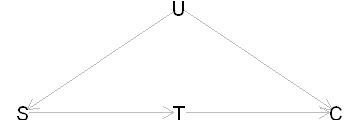

In [3]:
options(repr.plot.width=3, repr.plot.height=1)

# In this DAG U is latent
g1 = dagitty( 'dag {
    U [latent, pos="1,0"]
    S [exposure, pos="0,1"]
    T [pos="1,1"]
    C [outcome, pos="2,1"]        

    S <- U -> C
    S -> T -> C
}')

# In this DAG U is not latent
g2 = dagitty( 'dag {
    U [pos="1,0"]
    S [exposure, pos="0,1"]
    T [pos="1,1"]
    C [outcome, pos="2,1"]        

    S <- U -> C
    S -> T -> C
}')
plot(g1)

In case of graph *g1*, front-door criterion may be used. Below is the equicalent result due to do-calculus:

$
\begin{align*}
P(c \ | \ do(s)) & = \sum_t P(c \ | \ do(s), \ t) \ P(t \ | \ do(s)) \quad & \text{Laf of total probability} \\
& = \sum_t P(c \ | \ do(s), \ do(t)) \ P(t \ | \ do(s)) \quad & do(s) \text{ blocks bdp T<-S<-U->C ==> Rule 2} \\
& = \sum_t P(c \ | \ do(s), \ do(t)) \ P(t \ | \ s) \quad & \text{ no bdp b/w S and T ==> Rule 2} \\
& = \sum_t P(c \ | \ do(t)) \ P(t \ | \ s) \quad & \text{no causal path b/w S and C after controlling } do(t) \text{ ==> Rule 3} \\
& = \sum_{s'} \sum_t P(c \ | \ do(t), \ s') \ P(s' \ | \ do(t)) \ P(t \ | \ s) \quad & \text{Laf of total probability} \\
& = \sum_{s'} \sum_t P(c \ | \ t, \ s') \ P(s' \ | \ do(t)) \ P(t \ | \ s) \quad & s' \text{ blocks bdp T<-S<-U->C ==> Rule 2} \\
& = \sum_{s'} \sum_t P(c \ | \ t, \ s') \ P(s') \ P(t \ | \ s) \quad & \text{no causal path T->S ==> Rule 3} \\
\end{align*}
$

### Using dagitty on previous example
How can we obtain the result from dagitty here?

In [4]:
print(paths(g1))

$paths
[1] "S -> T -> C" "S <- U -> C"

$open
[1] TRUE TRUE



In [5]:
# Returns empty, as U is latent and there are no adjustment sets
print(adjustmentSets(g1, type = c("minimal","canonical", "all"), effect = c("total", "direct")))
print("---")
# Returns U
print(adjustmentSets(g2, type = c("minimal","canonical", "all"), effect = c("total", "direct")))

[1] "---"
 { U }


In [6]:
print(impliedConditionalIndependencies(g1))
print("---")
print(impliedConditionalIndependencies(g2))

[1] "---"
C _||_ S | T, U
T _||_ U | S


[1] "T" "S" "U"
[1] "S"


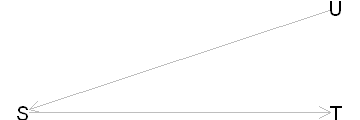

In [7]:
plot(ancestorGraph(g1, "T"))
print(ancestors(g1, "T"))
print(parents(g1, "T"))

In [8]:
print(descendants(g1, "T"))
print(children(g1, "T"))

[1] "T" "C"
[1] "C"


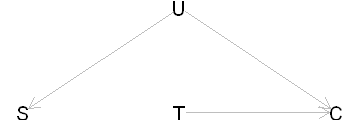

In [9]:
# Removes every first edge on a proper causal path from input graph
plot(backDoorGraph(g1))

In [10]:
print(dconnected(g1, "S", "C"))
print(dconnected(g1, "S", "C", c("T")))
print(dconnected(g1, "S", "C", c("U", "T")))
print("---")
print(dconnected(g2, "S", "C"))
print(dconnected(g2, "S", "C", c("T")))
print(dconnected(g2, "S", "C", c("U", "T")))

[1] TRUE
[1] TRUE
[1] FALSE
[1] "---"
[1] TRUE
[1] TRUE
[1] FALSE


## Example on closing back doors

Found in video [Causality: Closing Back Doors](https://www.youtube.com/watch?v=IajzIKW518M) by Nick Huntington-Klein.

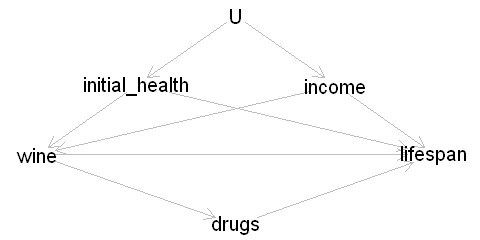

In [11]:
options(repr.plot.width=4, repr.plot.height=2)
ex2 = dagitty( 'dag {
    wine [exposure, pos="0,2"]
    lifespan [outcome, pos="4,2"]
    initial_health [pos="1,1"]
    income [pos="3,1"]
    drugs [pos="2,3"]
    U [latent, pos="2,0"]

    wine -> lifespan
    wine -> drugs -> lifespan
    initial_health <- U -> income
    wine <- initial_health -> lifespan
    wine <- income -> lifespan
}')
plot(ex2)

In [12]:
print(paths(ex2))

$paths
[1] "wine -> drugs -> lifespan"                        
[2] "wine -> lifespan"                                 
[3] "wine <- income -> lifespan"                       
[4] "wine <- income <- U -> initial_health -> lifespan"
[5] "wine <- initial_health -> lifespan"               
[6] "wine <- initial_health <- U -> income -> lifespan"

$open
[1] TRUE TRUE TRUE TRUE TRUE TRUE



 { income, initial_health }


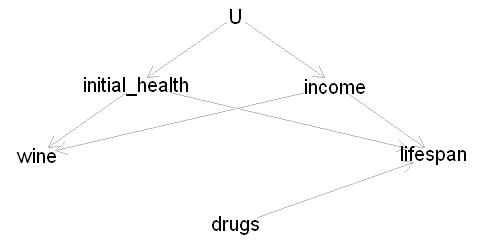

In [13]:
print(adjustmentSets(ex2))
plot(backDoorGraph(ex2))

In [14]:
print(impliedConditionalIndependencies(ex2))

drugs _||_ income | wine
drugs _||_ initial_health | wine
